In [26]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from pyHalo.preset_models import CDM
from pyHalo import plotting_routines
from copy import deepcopy
from lenstronomy.Util.correlation import power_spectrum_1d
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from galsim import InterpolatedImage, Image

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

import mejiro
from mejiro.lenses.test import SampleStrongLens
from mejiro.lenses import lens_util
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import ft
from mejiro.utils import util
from mejiro.helpers import gs, survey_sim, psf

In [35]:
# script configuration options
debugging = False
require_alignment = True
limit = 1000
snr_threshold = 50.
einstein_radius_threshold = 0.
log_m_host_threshold = 12.8

# set subhalo and imaging params
subhalo_params = {
    'r_tidal': 0.5,
    'sigma_sub': 0.055,
    'los_normalization': 0.
}
imaging_params = {
    'oversample': 5,
    'num_pix': 45,
    'side': 4.95,
    'control_band': 'F106',
    'exposure_time': 146,
}
bands = ['F106']
# bands = ['F106', 'F129', 'F158', 'F184']
position_control = {
    '2': (2048, 2048),
}
positions = {
    '9': (2048, 2048),
    '7': (2048, 2048),
    '16': (2048, 2048)
    # '9': (4, 4),
    # '17': (4092, 4092)
}

In [28]:
# for this notebook only
oversample = imaging_params['oversample']
num_pix = imaging_params['num_pix']
side = imaging_params['side']
control_band = imaging_params['control_band']
exposure_time = imaging_params['exposure_time']

In [29]:
# TODO compute zeropoints for each detector

In [30]:
# set output dir
save_dir = os.path.join(array_dir, 'power_spectra_dev')
util.create_directory_if_not_exists(save_dir)
util.clear_directory(save_dir)

# debugging? set pipeline dir accordingly
pipeline_params = util.hydra_to_dict(config.pipeline)
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

# collect lenses
print(f'Collecting lenses from {pipeline_dir}...')
lens_list = survey_sim.collect_all_detectable_lenses(os.path.join(pipeline_dir, '01'), suppress_output=False)
print(f'Collected {len(lens_list)} candidate lens(es).')

100%|██████████| 18/18 [00:09<00:00,  1.88it/s]


Collected 10074 candidate lens(es).


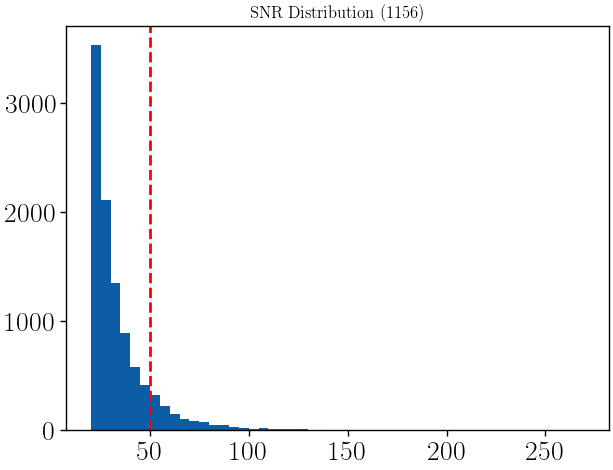

In [31]:
num_snr_cut = len([l.snr for l in lens_list if l.snr > snr_threshold and l.snr != np.inf])

plt.hist([l.snr for l in lens_list if l.snr != np.inf], bins=50)
plt.axvline(snr_threshold, color='red', linestyle='--')
plt.title(f'SNR Distribution ({num_snr_cut})')
plt.show()

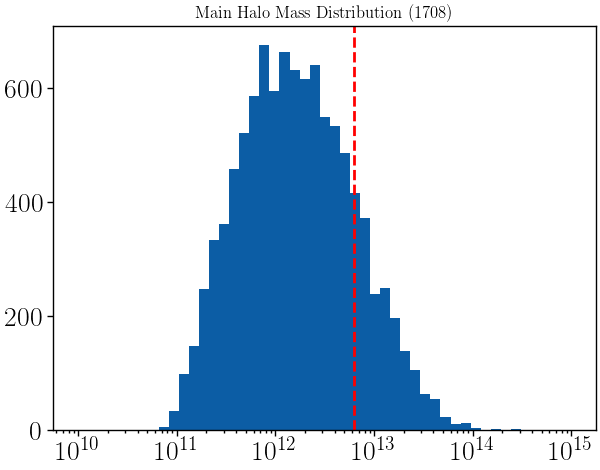

In [36]:
num_mass_cut = len([l.main_halo_mass for l in lens_list if l.main_halo_mass > 10 ** log_m_host_threshold])

plt.hist([l.main_halo_mass for l in lens_list], bins=np.logspace(10, 15, 50))
plt.axvline(10 ** log_m_host_threshold, color='red', linestyle='--')
plt.xscale('log')
plt.title(f'Main Halo Mass Distribution ({num_mass_cut})')
plt.show()

In [33]:
filtered_lenses = []
num_lenses = 0
for lens in lens_list:
    if lens.snr > snr_threshold and lens.get_einstein_radius() > einstein_radius_threshold and np.log10(
            lens.main_halo_mass) > log_m_host_threshold and lens.snr != np.inf:
        filtered_lenses.append(lens)
        num_lenses += 1
    if limit is not None and num_lenses >= limit:
        break
print(f'Collected {len(filtered_lenses)} lens(es).')

Collected 74 lens(es).


In [34]:
# repeat lenses up to limit
lenses_to_process = []
if limit is not None:
    repeats = int(np.ceil(limit / len(filtered_lenses)))
    print(f'Repeating lenses {repeats} times...')
    lenses_to_process = filtered_lenses * repeats
    lenses_to_process = lenses_to_process[:limit]

Repeating lenses 14 times...


In [40]:
# read cached PSFs
cached_psfs = {}
psf_cache_dir = os.path.join(config.machine.data_dir, 'cached_psfs')
psf_id_strings = []
for band in bands:
    for detector, detector_position in {**position_control, **positions}.items():
        psf_id_strings.append(
            psf.get_psf_id_string(band, detector, detector_position, imaging_params['oversample']))

for id_string in psf_id_strings:
    cached_psfs[id_string] = psf.load_cached_psf(id_string, psf_cache_dir, suppress_output=False)

Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_2_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_9_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_7_2048_2048_5.pkl
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_16_2048_2048_5.pkl


In [25]:
for i, lens in enumerate(filtered_lenses):
    print(f'{i}: StrongLens {lens.uid}, {np.log10(lens.main_halo_mass):.2f}, {lens.snr:.2f}')

0: StrongLens 00000153, 13.27, 51.97
1: StrongLens 00000518, 13.24, 170.10
2: StrongLens 00000545, 13.13, 76.27
3: StrongLens 00000592, 13.02, 54.26
4: StrongLens 00000605, 13.17, 57.54
5: StrongLens 00000736, 13.27, 61.40
6: StrongLens 00000778, 13.20, 57.72
7: StrongLens 00000807, 13.09, 56.00
8: StrongLens 00000906, 13.02, 96.49
9: StrongLens 00000987, 13.14, 50.68
10: StrongLens 00001103, 13.32, 51.87
11: StrongLens 00001420, 13.02, 60.23
12: StrongLens 00001622, 13.01, 61.04
13: StrongLens 00001658, 13.15, 81.02
14: StrongLens 00002110, 13.25, 112.90
15: StrongLens 00002123, 13.56, 55.85
16: StrongLens 00002164, 13.04, 60.38
17: StrongLens 00002288, 13.38, 62.98
18: StrongLens 00002294, 13.11, 57.96
19: StrongLens 00002300, 13.06, 52.86
20: StrongLens 00002351, 13.51, 52.34
21: StrongLens 00002501, 13.23, 61.34
22: StrongLens 00002520, 13.15, 53.35
23: StrongLens 00002557, 13.16, 67.50
24: StrongLens 00002591, 13.42, 75.52
25: StrongLens 00002605, 13.07, 69.39
26: StrongLens 00002

In [10]:
lens = filtered_lenses[5]  # 7
print(f'Processing StrongLens {lens.uid}...')

lens._set_classes()

Processing StrongLens 00007009...


In [11]:
def get_large(lens, subhalo_params):
    return CDM(round(lens.z_lens, 2),
               round(lens.z_source, 2),
               sigma_sub=subhalo_params['sigma_sub'],
               log_mlow=9.5,
               log_mhigh=11.,
               log_m_host=np.log10(lens.main_halo_mass),
               r_tidal=subhalo_params['r_tidal'],
               cone_opening_angle_arcsec=lens.get_einstein_radius() * 3,
               LOS_normalization=subhalo_params['los_normalization'])


def get_med(lens, subhalo_params):
    return CDM(round(lens.z_lens, 2),
               round(lens.z_source, 2),
               sigma_sub=subhalo_params['sigma_sub'],
               log_mlow=7.5,
               log_mhigh=9.5,
               log_m_host=np.log10(lens.main_halo_mass),
               r_tidal=subhalo_params['r_tidal'],
               cone_opening_angle_arcsec=lens.get_einstein_radius() * 3,
               LOS_normalization=subhalo_params['los_normalization'])


def get_small(lens, subhalo_params):
    return CDM(round(lens.z_lens, 2),
               round(lens.z_source, 2),
               sigma_sub=subhalo_params['sigma_sub'],
               log_mlow=6.,
               log_mhigh=7.5,
               log_m_host=np.log10(lens.main_halo_mass),
               r_tidal=subhalo_params['r_tidal'],
               cone_opening_angle_arcsec=lens.get_einstein_radius() * 6,
               LOS_normalization=subhalo_params['los_normalization'])

In [12]:
if require_alignment:
    aligned = False
    i = 0
    while not aligned:
        large = get_large(lens, subhalo_params)
        aligned = lens_util.check_halo_image_alignment(lens, large, halo_mass=5e9)
        i += 1
    print(f'Aligned in {i} iteration(s).')
else:
    large = get_large(lens, subhalo_params)
print(f'{len(large.halos)} subhalo(es) in large subhalo population.')

Aligned in 3 iteration(s).
5 subhalo(es) in large subhalo population.


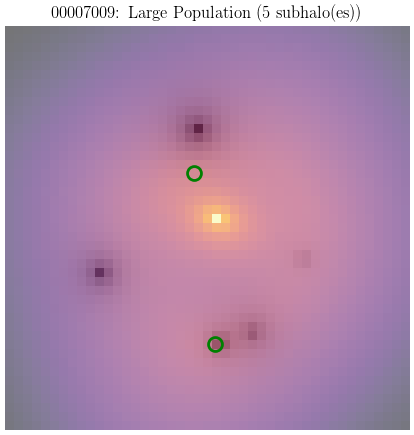

In [13]:
subhalo_lens = deepcopy(lens)
subhalo_lens.add_subhalos(large)
subhalo_kappa = subhalo_lens.get_subhalo_kappa(num_pix, side)
array = subhalo_lens.get_array(num_pix, side, control_band)
image_x, image_y = subhalo_lens.get_image_positions()

plt.imshow(np.log10(array), alpha=0.9, cmap='inferno')
plt.imshow(subhalo_kappa, alpha=0.4, cmap='binary')
plt.plot(image_x, image_y, 'go', ms=10, markeredgewidth=2, fillstyle='none')
plt.axis('off')
plt.title(f'{lens.uid}: Large Population ({len(large.halos)} subhalo(es))')
plt.show()

In [14]:
if require_alignment:
    aligned = False
    i = 0
    while not aligned:
        med = get_med(lens, subhalo_params)
        aligned = lens_util.check_halo_image_alignment(lens, med, halo_mass=5e8)
        i += 1
    print(f'Aligned in {i} iteration(s).')
else:
    med = get_med(lens, subhalo_params)
print(f'{len(med.halos)} subhalo(es) in medium subhalo population.')

Aligned in 3 iteration(s).
199 subhalo(es) in medium subhalo population.


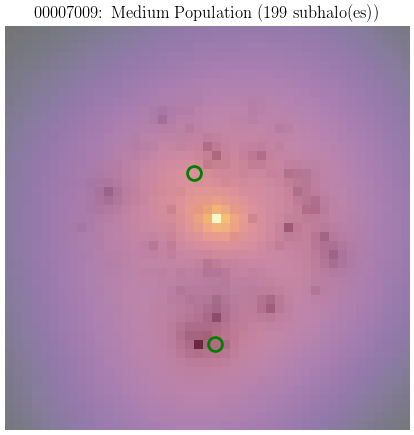

In [15]:
subhalo_lens = deepcopy(lens)
subhalo_lens.add_subhalos(med)
subhalo_kappa = subhalo_lens.get_subhalo_kappa(num_pix, side)
array = subhalo_lens.get_array(num_pix, side, control_band)
image_x, image_y = subhalo_lens.get_image_positions()

plt.imshow(np.log10(array), alpha=0.9, cmap='inferno')
plt.imshow(subhalo_kappa, alpha=0.4, cmap='binary')
plt.plot(image_x, image_y, 'go', ms=10, markeredgewidth=2, fillstyle='none')
plt.axis('off')
plt.title(f'{lens.uid}: Medium Population ({len(med.halos)} subhalo(es))')
plt.show()

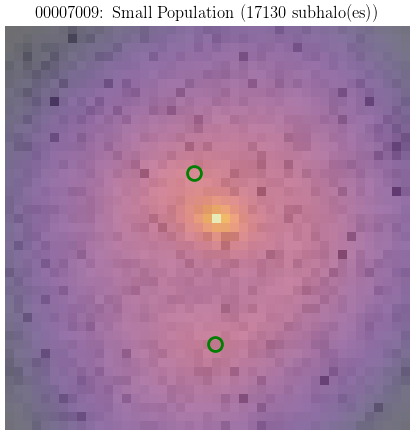

In [16]:
small = get_small(lens, subhalo_params)

subhalo_lens = deepcopy(lens)
subhalo_lens.add_subhalos(small)
subhalo_kappa = subhalo_lens.get_subhalo_kappa(num_pix, side)
array = subhalo_lens.get_array(num_pix, side, control_band)
image_x, image_y = subhalo_lens.get_image_positions()

plt.imshow(np.log10(array), alpha=0.75, cmap='inferno')
plt.imshow(subhalo_kappa, alpha=0.25, cmap='binary')
plt.plot(image_x, image_y, 'go', ms=10, markeredgewidth=2, fillstyle='none')
plt.axis('off')
plt.title(f'{lens.uid}: Small Population ({len(small.halos)} subhalo(es))')
plt.show()

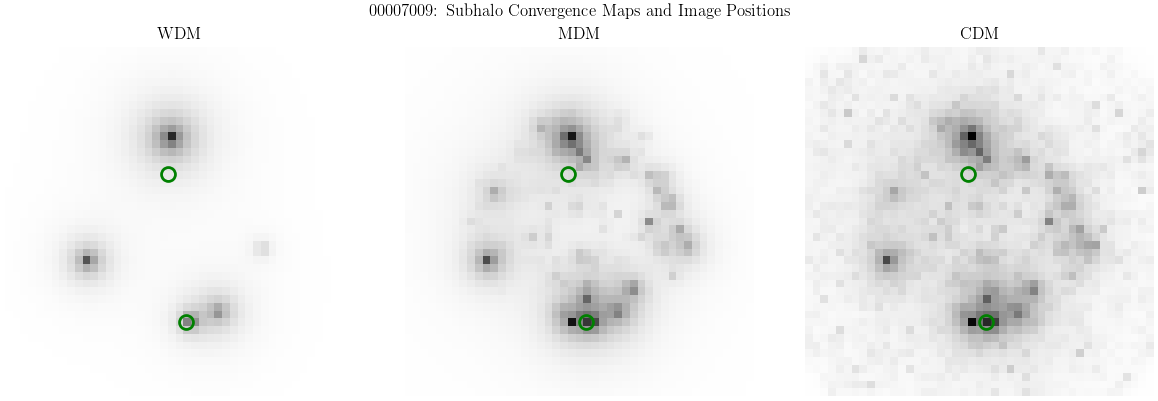

In [17]:
wdm = deepcopy(large)
mdm = wdm.join(med)
cdm = mdm.join(small)

wdm_lens = deepcopy(lens)
mdm_lens = deepcopy(lens)
cdm_lens = deepcopy(lens)

wdm_lens.add_subhalos(wdm)
mdm_lens.add_subhalos(mdm)
cdm_lens.add_subhalos(cdm)

wdm_kappa = wdm_lens.get_subhalo_kappa(num_pix, side)
mdm_kappa = mdm_lens.get_subhalo_kappa(num_pix, side)
cdm_kappa = cdm_lens.get_subhalo_kappa(num_pix, side)

vmin = 0
vmax = np.max([wdm_kappa, mdm_kappa, cdm_kappa])

_, ax = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
ax[0].imshow(wdm_kappa, cmap='binary', vmin=vmin, vmax=vmax)
ax[1].imshow(mdm_kappa, cmap='binary', vmin=vmin, vmax=vmax)
ax[2].imshow(cdm_kappa, cmap='binary', vmin=vmin, vmax=vmax)

ax[0].set_title('WDM')
ax[1].set_title('MDM')
ax[2].set_title('CDM')

for a in ax:
    a.axis('off')
    a.plot(image_x, image_y, 'go', ms=10, markeredgewidth=2, fillstyle='none')

plt.suptitle(f'{lens.uid}: Subhalo Convergence Maps and Image Positions')
plt.show()

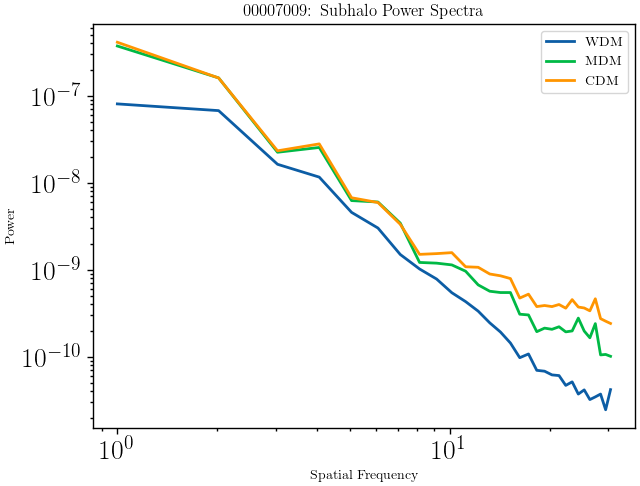

In [38]:
ps_wdm, r = power_spectrum_1d(wdm_kappa)
ps_mdm, _ = power_spectrum_1d(mdm_kappa)
ps_cdm, _ = power_spectrum_1d(cdm_kappa)

plt.plot(r, ps_wdm, label='WDM')
plt.plot(r, ps_mdm, label='MDM')
plt.plot(r, ps_cdm, label='CDM')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.legend()
plt.title(f'{lens.uid}: Subhalo Power Spectra')
plt.show()

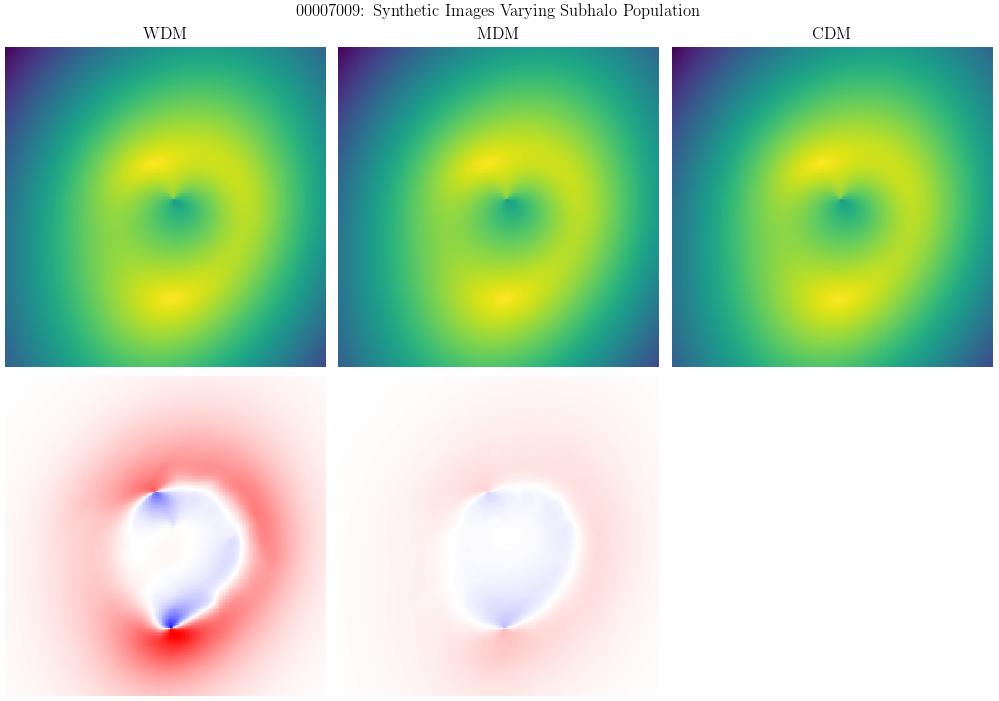

In [18]:
_, _, wdm_array = wdm_lens.get_array(num_pix * oversample, side, control_band, return_pieces=True)
_, _, mdm_array = mdm_lens.get_array(num_pix * oversample, side, control_band, return_pieces=True)
_, _, cdm_array = cdm_lens.get_array(num_pix * oversample, side, control_band, return_pieces=True)

wdm_residual = cdm_array - wdm_array
mdm_residual = cdm_array - mdm_array
min = np.min([wdm_residual, mdm_residual])
max = np.max([wdm_residual, mdm_residual])
vmax = np.max([np.abs(min), np.abs(max)])

_, ax = plt.subplots(2, 3, figsize=(10, 7), constrained_layout=True)
ax[0, 0].imshow(np.log10(wdm_array))
ax[0, 1].imshow(np.log10(mdm_array))
ax[0, 2].imshow(np.log10(cdm_array))
ax[1, 0].imshow(wdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 1].imshow(mdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)

ax[0, 0].set_title('WDM')
ax[0, 1].set_title('MDM')
ax[0, 2].set_title('CDM')

for a in ax.flatten():
    a.axis('off')

plt.suptitle(f'{lens.uid}: Synthetic Images Varying Subhalo Population')
plt.show()

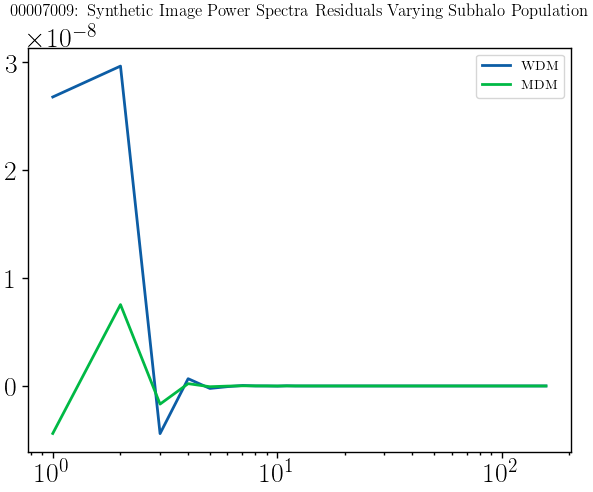

In [19]:
wdm_ps, r = power_spectrum_1d(wdm_array)
mdm_ps, _ = power_spectrum_1d(mdm_array)
cdm_ps, _ = power_spectrum_1d(cdm_array)

plt.plot(r, cdm_ps - wdm_ps, label='WDM')
plt.plot(r, cdm_ps - mdm_ps, label='MDM')
plt.xscale('log')
plt.title(f'{lens.uid}: Synthetic Image Power Spectra Residuals Varying Subhalo Population')
plt.legend()
plt.show()

In [28]:
def get_masked_exposure(lens, model, band, psf_kernel, num_pix, oversample, exposure_time):
    if type(psf_kernel) is np.ndarray:
        psf_kernel = psf.kernel_to_galsim_interpolated_image(psf_kernel, oversample)

    total_flux_cps = lens.get_total_flux_cps(band)
    interp = InterpolatedImage(Image(model, xmin=0, ymin=0), scale=0.11 / oversample,
                               flux=total_flux_cps * exposure_time)
    image = gs.convolve(interp, psf_kernel, num_pix)
    final_array = image.array

    # mask = np.ma.getmask(lens.masked_snr_array)
    data = lens.masked_snr_array.data
    strict_mask = np.ma.masked_where(data < 1., data)
    mask = np.ma.getmask(strict_mask)
    if mask.shape != final_array.shape:
        mask = util.center_crop_image(mask, final_array.shape)
    masked_image = np.ma.masked_array(final_array, mask)
    np.ma.set_fill_value(masked_image, 0)
    return masked_image.filled()

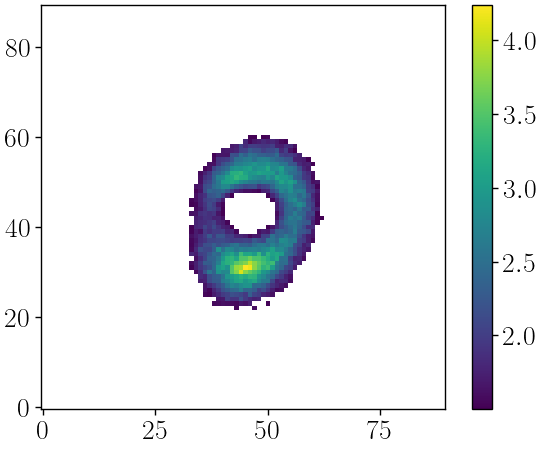

In [29]:
mask = np.ma.getmask(lens.masked_snr_array)
data = lens.masked_snr_array.data
strict_mask = np.ma.masked_where(data < 1.5, data)

plt.imshow(strict_mask)
plt.colorbar()
plt.show()

In [41]:
subhalos_psf_id_string = psf.get_psf_id_string(band=control_band, detector=2, detector_position=(2048, 2048),
                                               oversample=oversample)
subhalos_psf_kernel = cached_psfs[subhalos_psf_id_string]

wdm_exposure = get_masked_exposure(wdm_lens, wdm_array, control_band, subhalos_psf_kernel, num_pix, oversample,
                                   exposure_time)
mdm_exposure = get_masked_exposure(mdm_lens, mdm_array, control_band, subhalos_psf_kernel, num_pix, oversample,
                                   exposure_time)
cdm_exposure = get_masked_exposure(cdm_lens, cdm_array, control_band, subhalos_psf_kernel, num_pix, oversample,
                                   exposure_time)

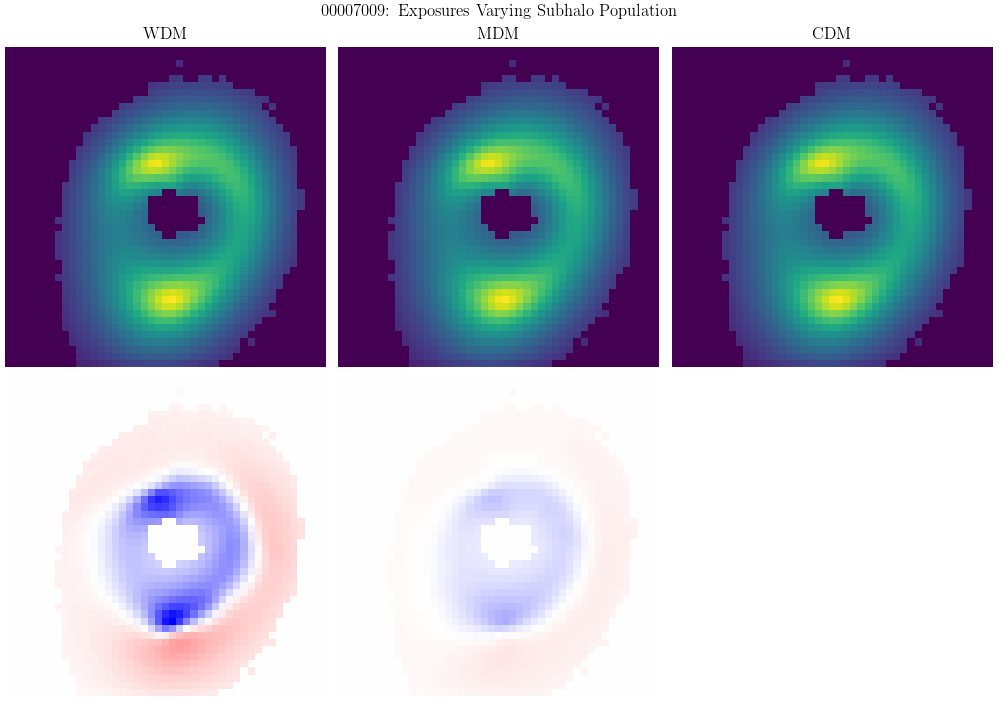

In [42]:
wdm_residual = cdm_exposure - wdm_exposure
mdm_residual = cdm_exposure - mdm_exposure
min = np.min([wdm_residual, mdm_residual])
max = np.max([wdm_residual, mdm_residual])
vmax = np.max([np.abs(min), np.abs(max)])

_, ax = plt.subplots(2, 3, figsize=(10, 7), constrained_layout=True)
ax[0, 0].imshow(wdm_exposure)
ax[0, 1].imshow(mdm_exposure)
ax[0, 2].imshow(cdm_exposure)
ax[1, 0].imshow(wdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 1].imshow(mdm_residual, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[0, 0].set_title('WDM')
ax[0, 1].set_title('MDM')
ax[0, 2].set_title('CDM')
for a in ax.flatten():
    a.axis('off')
plt.suptitle(f'{lens.uid}: Exposures Varying Subhalo Population')
plt.show()

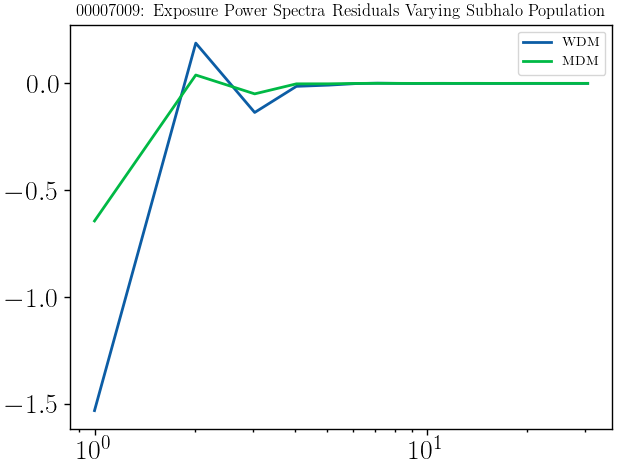

In [43]:
wdm_ps, r = power_spectrum_1d(wdm_exposure)
mdm_ps, _ = power_spectrum_1d(mdm_exposure)
cdm_ps, _ = power_spectrum_1d(cdm_exposure)

plt.plot(r, cdm_ps - wdm_ps, label='WDM')
plt.plot(r, cdm_ps - mdm_ps, label='MDM')
plt.xscale('log')
plt.title(f'{lens.uid}: Exposure Power Spectra Residuals Varying Subhalo Population')
plt.legend()
plt.show()

In [44]:
position_exposures = []
for detector, detector_position in {**position_control, **positions}.items():
    exposure = get_masked_exposure(cdm_lens, cdm_array, control_band, cached_psfs[
        psf.get_psf_id_string(control_band, detector, detector_position, oversample)], num_pix, oversample,
                                   exposure_time)
    position_exposures.append(exposure)

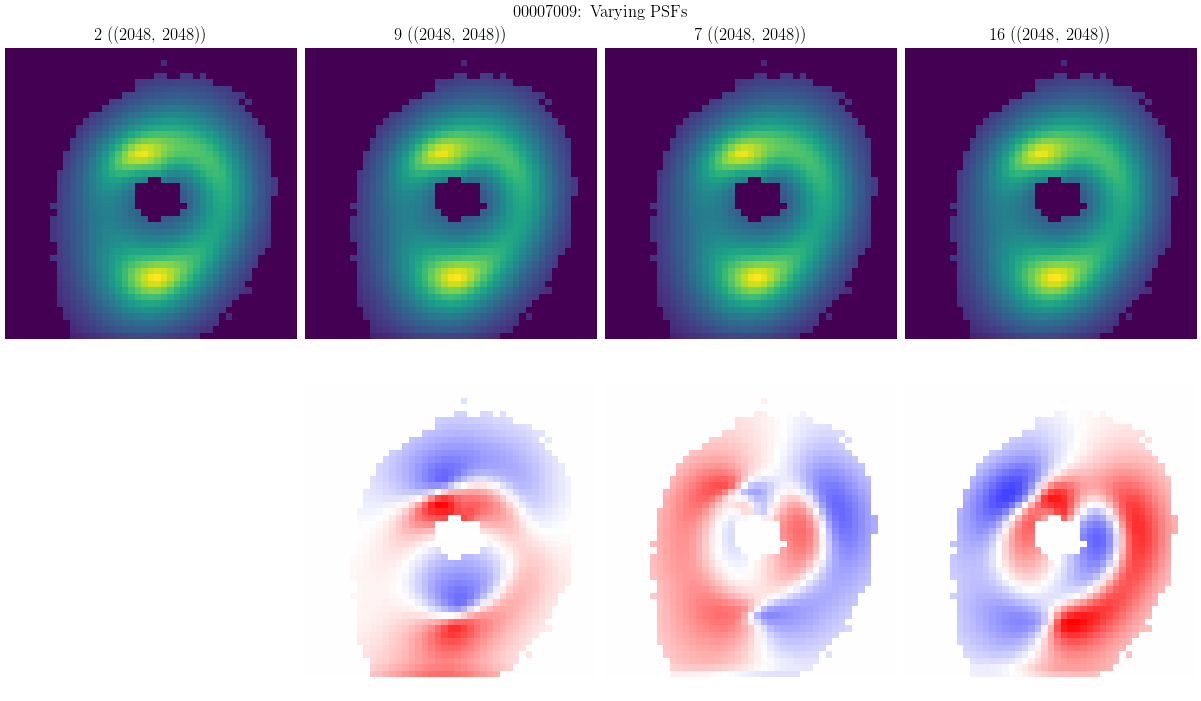

In [45]:
_, ax = plt.subplots(2, 4, figsize=(12, 7), constrained_layout=True)

ax[0, 0].imshow(position_exposures[0])
ax[0, 1].imshow(position_exposures[1])
ax[0, 2].imshow(position_exposures[2])
ax[0, 3].imshow(position_exposures[3])

res_1 = position_exposures[0] - position_exposures[1]
res_2 = position_exposures[0] - position_exposures[2]
res_3 = position_exposures[0] - position_exposures[3]

min = np.min([res_1, res_2, res_3])
max = np.max([res_1, res_2, res_3])
vmax = np.max([np.abs(min), np.abs(max)])

ax[1, 1].imshow(res_1, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 2].imshow(res_2, cmap='bwr', vmin=-vmax, vmax=vmax)
ax[1, 3].imshow(res_3, cmap='bwr', vmin=-vmax, vmax=vmax)

for i, (detector, detector_position) in enumerate({**position_control, **positions}.items()):
    ax[0, i].set_title(f'{detector} ({detector_position})')

for a in ax.flatten():
    a.axis('off')

plt.suptitle(f'{lens.uid}: Varying PSFs')
plt.show()

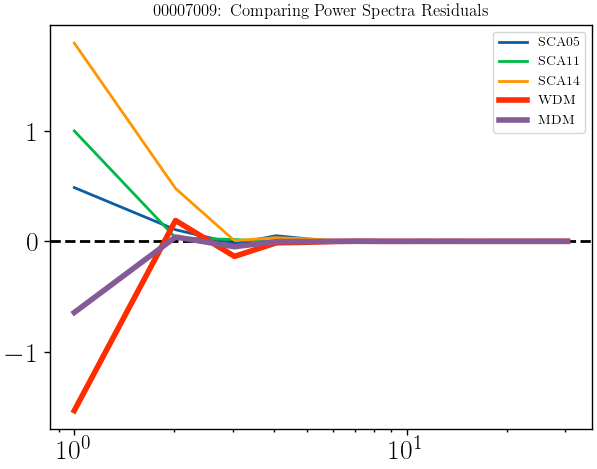

In [46]:
pos_0_ps, r = power_spectrum_1d(position_exposures[0])
pos_1_ps, _ = power_spectrum_1d(position_exposures[1])
pos_2_ps, _ = power_spectrum_1d(position_exposures[2])
pos_3_ps, _ = power_spectrum_1d(position_exposures[3])

plt.axhline(0, color='black', linestyle='--')
plt.plot(r, pos_0_ps - pos_1_ps, label='SCA05')
plt.plot(r, pos_0_ps - pos_2_ps, label='SCA11')
plt.plot(r, pos_0_ps - pos_3_ps, label='SCA14')
plt.plot(r, cdm_ps - wdm_ps, label='WDM', lw=4.)
plt.plot(r, cdm_ps - mdm_ps, label='MDM', lw=4.)
plt.xscale('log')
plt.title(f'{lens.uid}: Comparing Power Spectra Residuals')
plt.legend()
plt.show()